**Nome**: *Federico*
<br>
**Cognome**: *Signoretta*
<br>
**Numero matricola**: 847343
<br>
**E-mail**: f.signoretta@campus.unimib.it
<br>
**A.A.** 2019-2020




# Digital Signal and Image Management 
- Docente: *Simone Bianco*
- Docente: *Marco Buzzelli*
- Esercitatore: *Simone Zini*

## Assignment n.4
**Descrizione**: implementare una rete neurale per la classificazione del dataset MNIST a partire dalle istruzioni viste ad esercitazione.

Seguire la seguente struttura:

- Convoluzione bidimensionale con 32 filtri 3×3
- ReLU
- Max pooling bidimensionale con filtro 2×2
- Flattening
- Fully-connected che mappi a 128 dimensioni
- ReLU
- Fully-connected che mappi alla dimensione finale del problema

### 1. Import dei pacchetti

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

Using TensorFlow backend.


### 2. Caricamento dataset MNIST e visualizzazione delle immagini

In [2]:
# Dataset predefinito offerto da keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


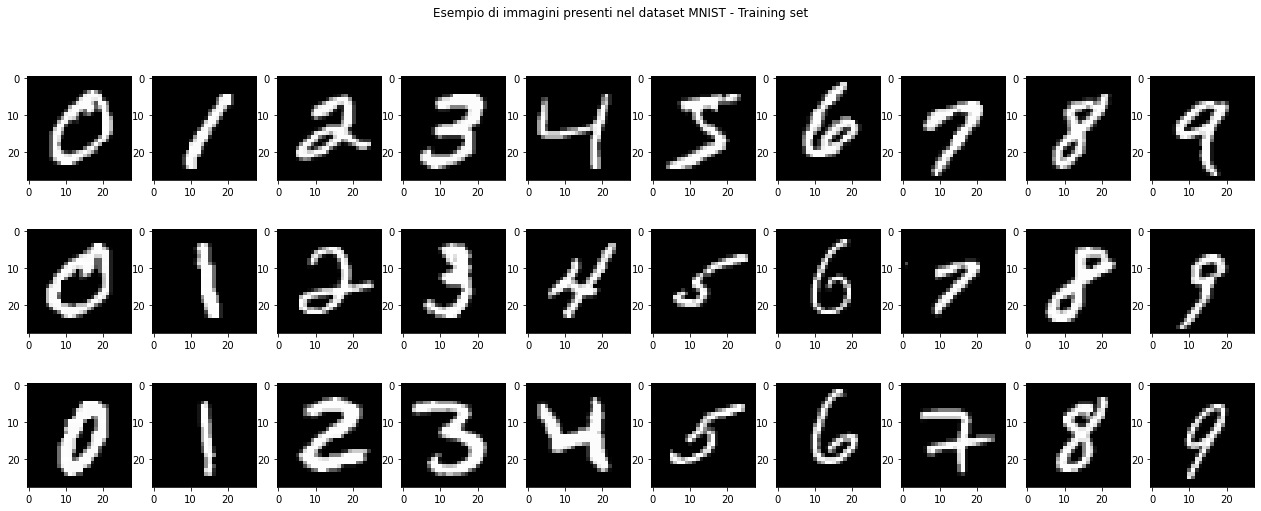

In [3]:
digits = [np.where(y_train==i)[0][:3] for i in np.unique(y_train)]
k=1
fig = plt.figure(figsize=(22,8))
for d1,d2,d3 in digits:
  fig.add_subplot(3,10,k)
  plt.imshow(X_train[d1,:,:], cmap='gray')
  fig.add_subplot(3,10,k+10)
  plt.imshow(X_train[d2,:,:], cmap='gray')
  fig.add_subplot(3,10,k+20)
  plt.imshow(X_train[d3,:,:], cmap='gray')
  k+=1
fig.suptitle('Esempio di immagini presenti nel dataset MNIST - Training set')
plt.show()

In [4]:
print('Training set:', X_train.shape)
print('Test set:', X_test.shape)

Training set: (60000, 28, 28)
Test set: (10000, 28, 28)


Il dataset preso in esame è contiene immagini di dimensione *28*x*28* di numeri da *0* a *9*, così suddivise:
- Training set: *60,000* immagini
- Test set: *10,000* immagini



### 3. Pre-processing
Le immagini e le labels, per essere processate in *keras*, hanno bisogno di essere leggermente modificate. In particolare, per le **immagini**, verrà aggiunta una dimensione dedicata al canale di colore e verrà cambiato il range di valori tra 0 e 1. Le **label** verranno trasformate attraverso il metodo *one-hot encoding*.
#### 3.1 Immagini

In [0]:
def preprocessing(X):
  X = np.expand_dims(X, axis=-1)
  X = X.astype('float32')/255.0
  return X

In [0]:
X_train = preprocessing(X_train)
X_test = preprocessing(X_test)

In [7]:
print('Training set:', X_train.shape)
print('Test set:', X_test.shape)

Training set: (60000, 28, 28, 1)
Test set: (10000, 28, 28, 1)


#### 3.2 Labels

In [0]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### 4. Definizione della rete neurale 
#### 4.1 Definizione della rete neurale senza Dropout
Vene definita la struttura delle rete neurale descrita inizialmente


In [9]:
model0 = Sequential()

model0.add(Conv2D(32, (3,3), input_shape=X_train.shape[1:]))
model0.add(Activation('relu'))
model0.add(MaxPooling2D((2,2), strides=2))
model0.add(Flatten())
model0.add(Dense(128))
model0.add(Activation('relu'))
model0.add(Dense(num_classes))
model0.add(Activation('softmax'))
model0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               692352    
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

#### 4.2 Definizione della rete neurale con Dropout
Vene definita la struttura delle rete neurale descrita inizialmente, con l'aggiunta di un layer di *Dropout*, in modo da contenere l'*overfitting*. Con la tecnica del *dropout*, durante la fase di addestramento del modello vengono spenti dei neuroni e quindi ignorati con un determinato *rate*. Il *rate* di dropout scelto in questo caso è di *0.5*

In [10]:
model1 = Sequential()

model1.add(Conv2D(32, (3,3), input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D((2,2), strides=2))
model1.add(Flatten())
model1.add(Dense(128))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_4 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               692352    
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

La reti così implementate risultano essere piuttosto leggere. Infatti, il totale dei parametri trainabili è circa *700k*.

### 5. Addestramento della rete e risultati
Per l'addestramento del modello verrà utilizzata come funzione di *loss* la *categorical crossentropy* e come ottimizzatore *adam*. La *batch size* viene fissata a *128* e il numero di *epoche* viene fissato a *20*.



In [0]:
def plot_history(history):
  fig = plt.figure(figsize=(18,6))

  fig.add_subplot(1,2,1)
  plt.plot(history.history['accuracy'], marker='.')
  plt.plot(history.history['val_accuracy'], marker='.')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  fig.add_subplot(1,2,2)
  plt.plot(history.history['loss'], marker='.')
  plt.plot(history.history['val_loss'], marker='.')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

#### 5.1 Addestramento *model0*

In [12]:
model0.compile(loss='categorical_crossentropy',
              optimizer = 'adam', metrics=['accuracy'])

%time history0 = model0.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=128, epochs=20, verbose=0)

CPU times: user 46.6 s, sys: 10.1 s, total: 56.7 s
Wall time: 58.5 s


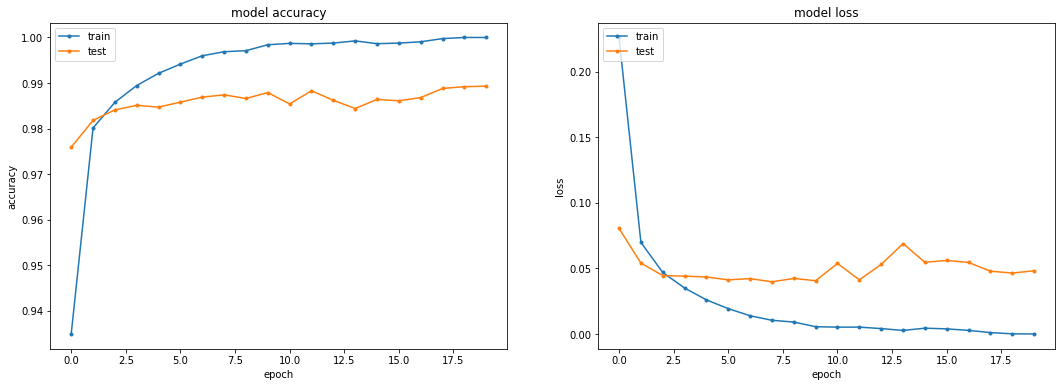

In [13]:
plot_history(history0)

#### 5.2 Addestramento *model1*

In [14]:
model1.compile(loss='categorical_crossentropy',
               optimizer = 'adam', metrics=['accuracy'])

%time history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=128, epochs=20, verbose=0)

CPU times: user 46.1 s, sys: 11.2 s, total: 57.3 s
Wall time: 53.8 s


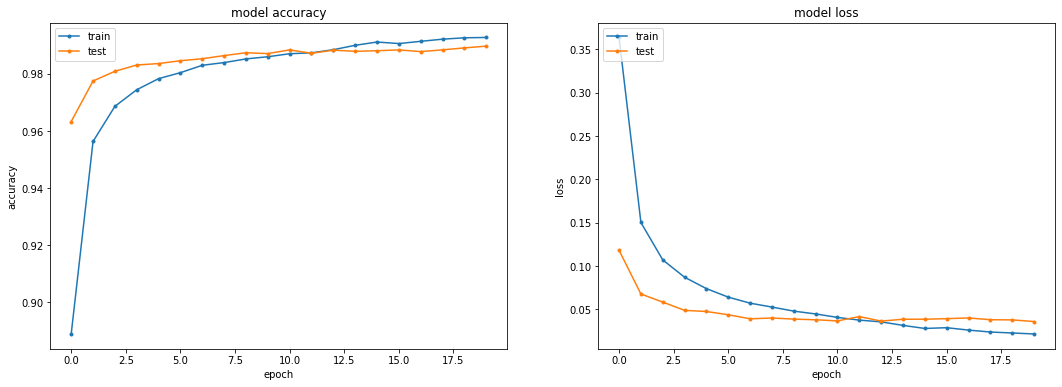

In [15]:
plot_history(history1)

#### 5.3 Predizione sul test set e permormance sulle classi del modello migliore

In [16]:
y_pred = model1.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
print(classification_report(y_test, y_pred, digits = 2))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.98       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### 6. Conclusioni
Il modello migliore risulta essere il *model1*, ossia la rete con layer di *dropout*. Sebbene questa rete sia semplicemente composta da uno strato convoluzionale (*Con2D* e *MaxPooling*) e da un *hidden layer* da 128 neuroni, riesce a raggiungere delle ottime performance sui dati di test. Infatti, all'incirca su tutte le classi, essa riesce a raggiungere un *f1-score* vicino al *99%*. L'overfitting sembra essere stato gestito nel modo corretto, attraverso l'inserimento del layer di *dropout*. Il motivo di queste ottime performance sono senza dubbio dovute alla semplicità del task ed alla similarità tra le immagini di test e di train. 